In [1]:
# Python was used for data processing, statistical analysis, and optimization
# environment setup
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Large-cap, diversified
# defining stocks and time period
stocks = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS",
    "INFY.NS", "ITC.NS", "LT.NS", "HINDUNILVR.NS",
    "M&M.NS", "SUNPHARMA.NS"
]

benchmark = "^NSEI"

start_date = "2022-01-01"
end_date = "2025-01-01"

In [3]:
# Date alignment and missing value handling
# download market data
price_data = yf.download(stocks, start=start_date, end=end_date)["Close"]
benchmark_data = yf.download(benchmark, start=start_date, end=end_date)["Close"]

C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_10560\2866355010.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(stocks, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  10 of 10 completed
C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_10560\2866355010.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data = yf.download(benchmark, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


In [4]:
#data cleaning
price_data = price_data.dropna()
benchmark_data = benchmark_data.loc[price_data.index]


In [5]:
#return calculation
returns = price_data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()
returns

Ticker,HDFCBANK.NS,HINDUNILVR.NS,ICICIBANK.NS,INFY.NS,ITC.NS,LT.NS,M&M.NS,RELIANCE.NS,SUNPHARMA.NS,TCS.NS
Date,,,,,,,,,,
2022-01-04,0.005856,0.016918,0.010658,0.000369,0.005249,0.007645,0.002470,0.022568,-0.013252,0.017550
2022-01-05,0.023748,0.006059,0.019667,-0.028697,0.001362,0.005703,0.009196,0.004678,-0.003104,-0.006127
2022-01-06,-0.016040,-0.010100,-0.003807,-0.014555,-0.008388,-0.012368,0.000417,-0.021502,-0.006586,-0.013857
2022-01-07,0.007014,0.010350,0.010445,-0.001926,-0.001372,-0.010184,-0.012919,0.008070,-0.000784,0.012095
2022-01-10,0.005546,-0.003766,0.022061,0.020091,0.022436,0.025303,0.015621,0.000821,-0.002714,0.006838
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.001610,-0.001432,0.000347,-0.007925,0.008856,-0.000206,0.006668,0.000368,0.002425,0.005098
2024-12-26,-0.004088,-0.001199,0.000077,-0.000864,-0.003135,-0.002816,0.016031,-0.005071,0.012287,-0.002488
2024-12-27,0.004188,0.003644,0.007862,0.004902,0.003459,-0.005896,0.024801,0.003699,0.010807,-0.001019


In [6]:
#anualized metrics
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
annual_nifty_returns = benchmark_returns.mean()* 252
annual_nifty_volatility=benchmark_returns.std()* np.sqrt(252)
annual_nifty_volatility

Ticker
^NSEI    0.140573
dtype: float64

In [7]:
# Portfolio risk depends on covariance, not individual risk
# risk Structure
cov_matrix = returns.cov() * 252
corr_matrix = returns.corr()

In [ ]:
# equal weight portfolio
num_assets = len(stocks) 
equal_weights = np.array([1/num_assets]*num_assets)

eq_return = np.dot(equal_weights, annual_returns)
eq_volatility = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))
eq_sharpe = (eq_return-0.067)/ eq_volatility # 6.67 % risk free rate for 10 year govt bond
nifty_sharpe=(annual_nifty_returns-0.067)/annual_nifty_volatility

In [ ]:
# portfolio optimization (core project)
# Objective : maximize Sharpe ratio
def portfolio_performance(weights):
    returns_p = np.dot(weights, annual_returns)
    volatility_p = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_p = (returns_p - 0.067)/ volatility_p # 6.67 % risk free rate for 10 year govt bond
    return returns_p, volatility_p, sharpe_p


In [10]:
# optimization function
def neg_sharpe(weights):
    return -portfolio_performance(weights)[2]

In [11]:
# constraints 
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

In [12]:
# running optimization
result = minimize(
    neg_sharpe,
    equal_weights,
    method='SLSQP',#Sequencial least square programming algorithm
    bounds=bounds,
    constraints=constraints
)

opt_weights = result.x

In [13]:
# optimized portfolio metrics
# Optimization improved the Sharpe ratio while controlling portfolio volatility
opt_return, opt_volatility, opt_sharpe = portfolio_performance(opt_weights)
portfolio_performance(opt_weights)
opt_volatility

np.float64(0.15484502614879803)

In [14]:
#portfolio growth comparison and draw
portfolio_eq = (returns @ equal_weights).cumsum() #return@equal weights - matrix multiplication (weights*returns) .cumsum() - cumilative sum of returns
portfolio_opt = (returns @ opt_weights).cumsum()
benchmark_growth = benchmark_returns.cumsum()
opt_drawdown = (1+portfolio_opt)/(1+portfolio_opt).cummax() - 1
eq_drawdown = (1+portfolio_eq)/(1+portfolio_eq).cummax() - 1
benchmark_drawdown = (1+benchmark_growth)/(1+benchmark_growth).cummax() - 1
#portfolio_eq.head(), portfolio_opt.head(), benchmark_growth.tail()


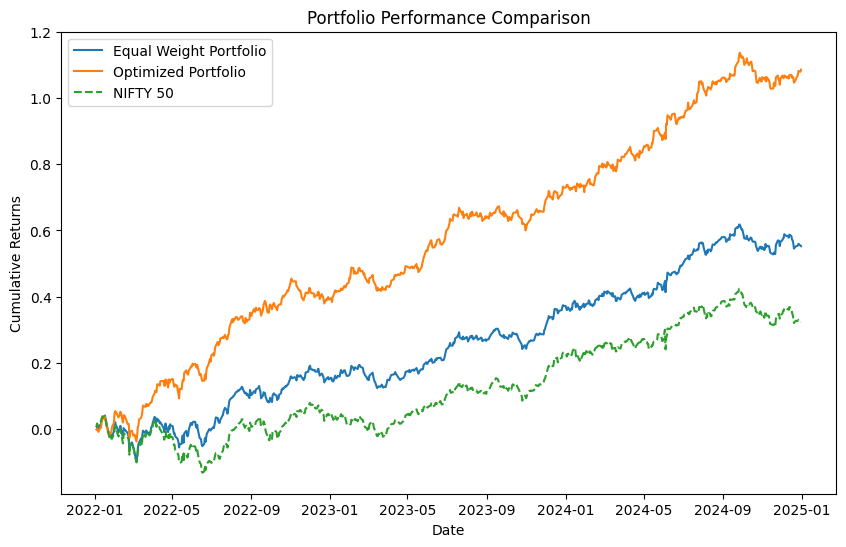

In [15]:
#Visualization
plt.figure(figsize=(10,6))
plt.plot(portfolio_eq, label="Equal Weight Portfolio")
plt.plot(portfolio_opt, label="Optimized Portfolio")
plt.plot(benchmark_growth, label="NIFTY 50", linestyle="--")
plt.legend()
plt.title("Portfolio Performance Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()

In [16]:
#weights comparison
# risk concentration & diversification
def_weights=pd.DataFrame({'Stocks':stocks,'equal weights':equal_weights,'optimized weights':opt_weights})
def_weights.sort_values('optimized weights', ascending=False)

,Stocks,equal weights,optimized weights
4,INFY.NS,0.1,3.885017e-01
6,LT.NS,0.1,3.110973e-01
8,M&M.NS,0.1,3.004010e-01
7,HINDUNILVR.NS,0.1,3.394373e-16
3,ICICIBANK.NS,0.1,3.227808e-16
9,SUNPHARMA.NS,0.1,1.556891e-16
0,RELIANCE.NS,0.1,1.073365e-16
5,ITC.NS,0.1,1.046599e-16
1,TCS.NS,0.1,8.354627e-17
2,HDFCBANK.NS,0.1,7.059462e-17


In [17]:
#key result Summery
summery=pd.DataFrame({'portfolio':['equal weights', 'optimized','benchmark'],
                      'Return':[eq_return,opt_return,float(annual_nifty_returns)], 
                      'volatility':[eq_volatility,opt_volatility, float(annual_nifty_volatility)],
                      'sharpe ratio':[eq_sharpe,opt_sharpe,float(nifty_sharpe)]})
summery
#Portfolio optimization was done using mean–variance framework
#Risk was measured using volatility and covariance
#Sharpe ratio was used to compare risk-adjusted performance
#Benchmark comparison validated portfolio efficiency

C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_10560\2950634244.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Return':[eq_return,opt_return,float(annual_nifty_returns)],
C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_10560\2950634244.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'volatility':[eq_volatility,opt_volatility, float(annual_nifty_volatility)],
C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_10560\2950634244.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'sharpe ratio':[eq_sharpe,opt_sharpe,float(nifty_sharpe)]})


,portfolio,Return,volatility,sharpe ratio
0,equal weights,0.188715,0.134153,0.907288
1,optimized,0.370796,0.154845,1.961939
2,benchmark,0.110237,0.140573,0.307573


In [18]:
# Risk Contribution Analysis
 # step 1 - find marginal risk by multiplying it by weights step 2 - multiply found marginal risk by weights and divide it by variance (2*volatility)
eq_wt_risk_contribution= equal_weights*np.dot(equal_weights,cov_matrix)/(eq_volatility*eq_volatility)
opt_weight_risk_contribution=opt_weights*np.dot(opt_weights,cov_matrix)/(opt_volatility*opt_volatility)
risk_contributions=pd.DataFrame({'Stocks':stocks,'equal weights':equal_weights,
                                 'Equal Weight Risk Contribution':eq_wt_risk_contribution,'optimized weights':opt_weights,
                                 'Optimized Weight Risk Contribution':opt_weight_risk_contribution})

In [19]:
# data export to csv
# price data
price_long=price_data.reset_index().melt(id_vars="Date", var_name="Stocks", value_name="Close")
returns_long=returns.reset_index().melt(id_vars="Date", var_name="Stocks", value_name="Daily_Return")
portfolio_eq_daily=returns@equal_weights
portfolio_opt_daily = returns@opt_weights
portfolio_daily=pd.DataFrame({"Date": returns.index,"Equal_Portfolio": portfolio_eq_daily.squeeze()
                              ,"Optimized_Portfolio": portfolio_opt_daily.squeeze(),
                              "NIFTY": benchmark_returns.loc[returns.index].squeeze(),
                              "cumulative_NIFTY": benchmark_growth.loc[returns.index].squeeze(),
                              "cumulative_Equal": portfolio_eq.squeeze(),
                              "cumulative_Optimized": portfolio_opt.squeeze(),
                              "Equal_Drawdown": eq_drawdown.squeeze(),
                              "Optimized_Drawdown": opt_drawdown.squeeze(),
                              "Benchmark_Drawdown": benchmark_drawdown.squeeze()
                              })
weights_df=pd.DataFrame({'Stocks':stocks,'Equal Weights':equal_weights,'OPtimized Weights':opt_weights})

# price_long.to_csv("Prices.csv",index=False)
# returns_long.to_csv("Returns.csv",index=False)
# portfolio_daily.to_csv("Portfolio_Daily_Returns.csv",index=False)
# weights_df.to_csv("Portfolio_Weights.csv",index=False)
# summery.to_csv("Portfolio_Summary.csv",index=False)
with pd.ExcelWriter("Portfolio_Analysis.xlsx") as writer:
    price_long.to_excel(writer, sheet_name="Prices", index=False)
    returns_long.to_excel(writer, sheet_name="Returns", index=False)
    portfolio_daily.to_excel(writer, sheet_name="Portfolio_Daily_Returns", index=False)
    weights_df.to_excel(writer, sheet_name="Portfolio_Weights", index=False)
    summery.to_excel(writer, sheet_name="Portfolio_Summary", index=False)
    corr_matrix.to_excel(writer, sheet_name="Correlation_Matrix", index=True)
    risk_contributions.to_excel(writer, sheet_name="Risk_Contributions", index=False)
